In [2]:
import pandas as pd
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
import json  

#Config
#Model accuracy goes down when analyzing too many repos at the same time. Only add multiple repos here if there is an overlap in users.
data_path=['Data/repos/first-project','Data/repos/second-project','Data/repos/third-project','../../'] # result from 'Data/repos/fourth-project' seem weird with the most changed files being ".gitignore" and a ".lock" file so i excluded it here
blacklist=["/mallet/"] # exclude all paths that contain one of these strings
mapping_json_path="usermappings.json" #Known useridentities, as git does not ensure the username is actually something like the account name. In other words one user can have infinite different usernames.
training_data_cutoff=2000 # Ignore filechanges larger than this. It is assumed to be data, not code.
exclude_extenstions=["json","pickle","csv"]
amplify_non_change=5 # How often a it should be encoded that a user that did not change a file at all, does 0 change to it. Setting this to low will cause the model to output too large estimation. DO NOT SET TO 0! Setting it to 0 WILL cause the model to focus on the file, instead of on the developer and respond with the same estimation for each dev.
min_commits=2 # Amount of times a file has to be changed to track it.

cpu_threads=os.cpu_count() #Change this to how many CPU threads you want to use, incase you dont want to use all of them

known_usermappings={}
git_command_template='git -C PATH log  --date=local --all --pretty="@ %h;%an;%ad;" --stat=1000'
if os.path.isfile(mapping_json_path):
    with open(mapping_json_path) as json_file:
        known_usermappings = json.load(json_file)
value_name='changes'
blacklist=list(map(lambda x:x.replace("\\","/"),blacklist))

16

In [2]:
def map_username(name):
    if name in known_usermappings.keys():
        return known_usermappings[name]
    else:
        return name
def is_excluded_folder(path):
    
    for bl_instance in blacklist:
        if bl_instance in path:
            return True
    
    return False

In [3]:
#Load data
all_file_names =set()
all_known_users =set()
input_data=[]
user_changed={}
for git_dir in data_path:
    user="" 
    git_result=!{git_command_template.replace("PATH",git_dir)}
    git_result=list(map(lambda x: x.replace("-","").replace("+",""),git_result))
    file_changed_counter={}
    #get how often a certain file was changed for "min_commits" functionality
    for line in git_result:
        if "|" in line:
            line=line.replace(" ","")
            filename=line.split("|")[0]
            changes=line.split("|")[1].strip()
            if changes.isnumeric() and not is_excluded_folder(filename):
                if not filename in file_changed_counter:
                    file_changed_counter[filename]=1
                else:
                    file_changed_counter[filename]=  file_changed_counter[filename]+1
    #Actually parse git output.
    for line in git_result:
        line=line.replace(" ","")
        if "@" in line:
            user=map_username(line.split(";")[1])
            all_known_users.add(user)
            if user not in user_changed:
                user_changed[user]=set()
        if "|" in line:
            filename=line.split("|")[0]
            changes=line.split("|")[1].strip()
            if changes.isnumeric() and filename in file_changed_counter.keys() and file_changed_counter[filename]>=min_commits:
                changed_lines=int(changes)
                file_extension=filename.split(".")[-1]
                if changed_lines<training_data_cutoff and not file_extension in exclude_extenstions: # Assumption: changed_lines>training_data_cutoff would be training data or some kind of template.
                    all_file_names.add(filename)
                    input_data.append([user,filename,file_extension,int(changes)])
                    user_changed[user].add(filename)
                
fake_data = [] # If a user has not changed a file, encode this information explicitly!
for user in all_known_users:
    for file in all_file_names:
        if file not in user_changed[user]:
            fake_data.append([user,file,file.split(".")[-1],0])
for i in range(0,amplify_non_change):  
    input_data=input_data+fake_data

In [4]:
# clean up data
data = pd.DataFrame(input_data, columns =['username', 'filename','file_ext', 'changes'], dtype = int)
data = pd.get_dummies(data,columns=['username'])
data = pd.get_dummies(data,columns=['filename'])
data = pd.get_dummies(data,columns=['file_ext'])


In [5]:
print('The shape of our features is:', data.shape)


The shape of our features is: (6995, 186)


In [6]:
# Using Skicit-learn to split data into training and testing sets
from sklearn.model_selection import train_test_split

x = data.drop(value_name, 1)
y = data[value_name]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)


,username_0l93idrnjb,username_3kl3vgfdzh,username_7epjkqfmdn,username_8ujqppa72v,username_cygqivx1jn,username_g7orerhcub,username_l3irkh4drd,username_mbhp3m2k5o,username_valentin,username_vxu42sqw1r,...,file_ext_nltk_data/tokenizers/punkt/PY3/README,file_ext_nltk_data/tokenizers/punkt/README,file_ext_prefs,file_ext_project,file_ext_properties,file_ext_py,file_ext_soy,file_ext_stk,file_ext_txt,file_ext_xml
5118,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4104,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4350,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
263,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
5403,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [7]:
# Import the model we are using
from sklearn.ensemble import RandomForestRegressor# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42,criterion='mae',n_jobs=cpu_threads)# Train the model on training data
#Enable verbose logging to at least get some output while waiting.
rf.verbose=True
#This can take a while depending on your data/CPU
rf.fit(x_train, y_train);
rf.verbose=False


[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:   20.7s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:  2.6min
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:  6.3min
[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed: 11.2min
[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed: 14.6min finished


In [8]:
predictions = rf.predict(x_test)
errors = abs(predictions - y_test) # Calculate the absolute errors
print('Mean Absolute Error:', round(np.mean(errors), 2))
errors=list(filter(lambda x: x > 1, errors)) #Errors smaller than 1 are most likly the added 0 for non changed files
print('Mean Absolute Errors Of Errors >= 1:', round(np.mean(errors), 2))
print('Max Error: ',np.max(errors),".")

Mean Absolute Error: 5.14
Mean Absolute Errors Of Errors >= 1: 38.41
Max Error:  1211.492 .


In [9]:
#predict for all users and all files how much is expected to change. Save in a way that can be easy dumped to json
all_predictions = []
for user in all_known_users:
    user_pred=[]
    for file in all_file_names:
        elem=pd.DataFrame([[0]*(len(x.columns))], columns =x.columns)
        elem["username_"+user]=1
        elem["filename_"+file]=1
        elem["file_ext_"+file.split(".")[-1]]=1
        prediction=rf.predict(elem)
        user_pred.append({"filename":file, "expected_change":prediction[0]})
    user_pred.sort(key=lambda x:x["expected_change"],reverse=True)
    print("done with predictions for user:",user)
    all_predictions.append({"username":user,"prediction":user_pred})

with open('result.json', 'w') as outfile:
    json.dump(all_predictions,outfile)


done with predictions for user: l3irkh4drd
done with predictions for user: 3kl3vgfdzh
done with predictions for user: wuwubahv1t
done with predictions for user: cygqivx1jn
done with predictions for user: 0l93idrnjb
done with predictions for user: mbhp3m2k5o
done with predictions for user: 7epjkqfmdn
done with predictions for user: 8ujqppa72v
done with predictions for user: vxu42sqw1r
done with predictions for user: g7orerhcub
done with predictions for user: valentin


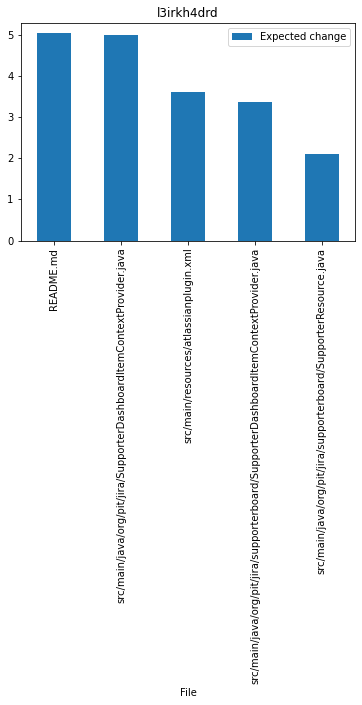

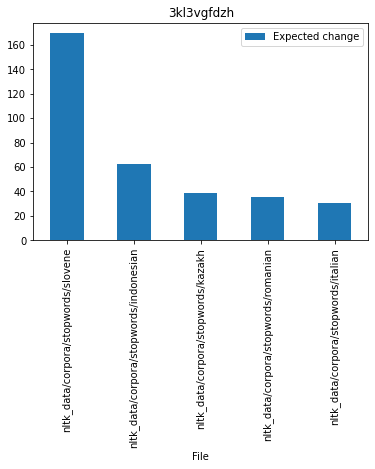

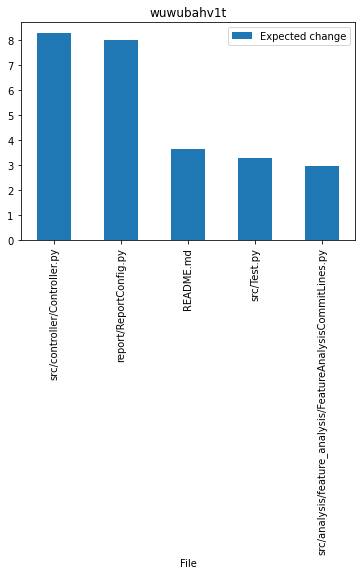

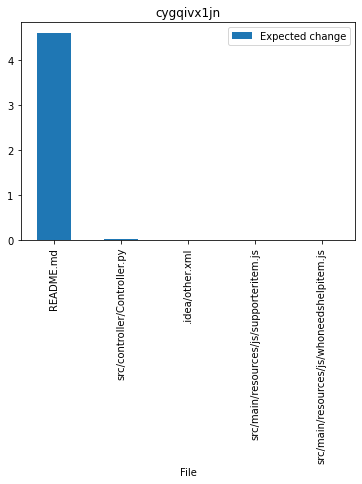

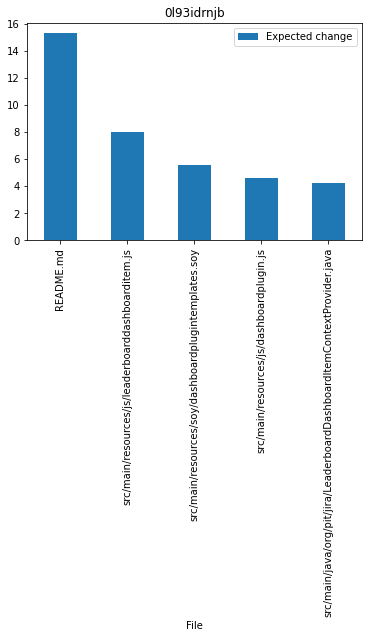

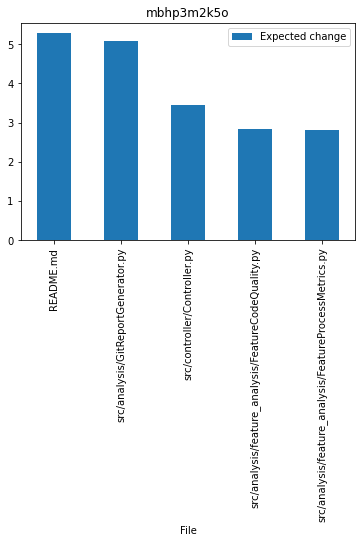

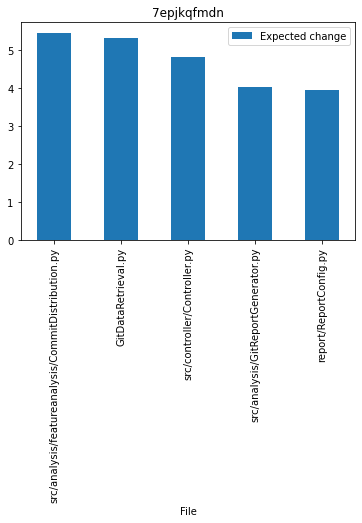

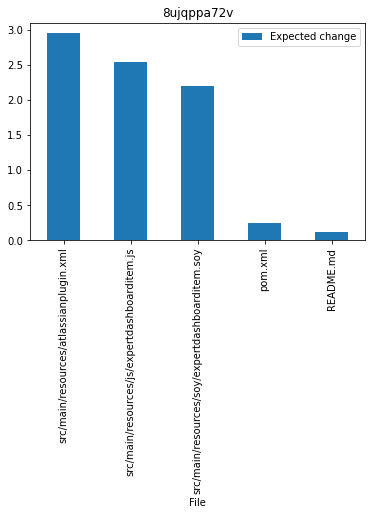

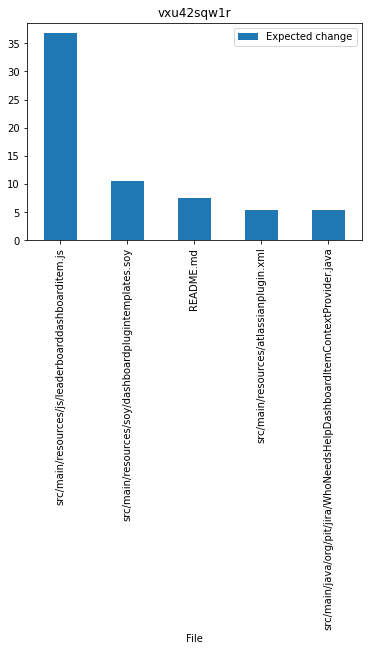

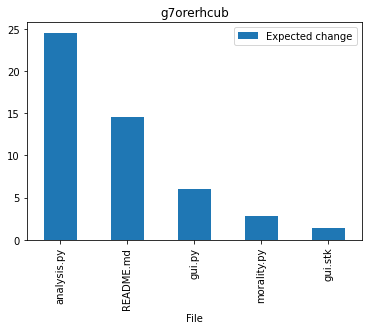

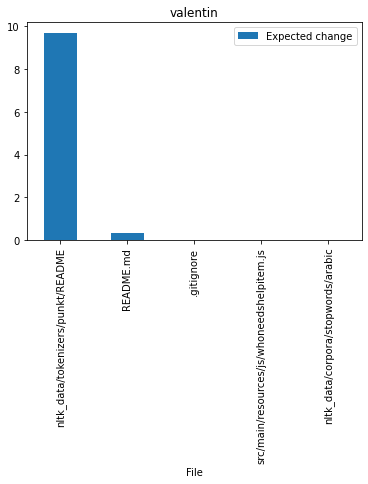

In [10]:
#Displying some bar graphs. This is only for debugging relevant. This cell has to influence to the exported results
for elem in all_predictions:
    user=elem["username"]
    pred=elem["prediction"]
    pred.sort(key=lambda x:x["expected_change"],reverse=True)
    relevant_dat=pred[0:5]
    file_names=list(map(lambda x:x["filename"],relevant_dat))
    prediction_dat=list(map(lambda x:x["expected_change"],relevant_dat))
    df = pd.DataFrame({'File':file_names, 'Expected change':prediction_dat})
    ax = df.plot.bar(x='File', y='Expected change', rot=90,title=user)